## Serial test

Idea: break the sequence $x_1, x_2, x_3, ..., x_{2n}$ into consecutive series of length $2$: $(x_1, x_2), (x_3, x_4), ..., (x_{2n-1}, x_{2n})$ and look at each element as a random and independent point in $2D$ space. Next, apply chi-square. Similarly, one can construct series of length $3, 4$, etc.

### Problem 1
Implement serial test and apply to a `samples`

In [ ]:
import numpy as np
from scipy.stats import chi2

def serial_test(sequence, d=2, k=10, alpha=0.05):
    n = len(sequence)
    if n % d != 0:
        print(f"Sequence length must be divisible by {d}.")
        return None

    # Reshape into tuples of size d
    tuples = np.array(sequence).reshape(-1, d)

    # Normalize to [0, 1) range
    tuples = (tuples - np.min(tuples)) / (np.max(tuples) - np.min(tuples))

    # Create bins for each dimension
    bins = [np.linspace(0, 1, k + 1) for _ in range(d)]

    # Compute the multi-dimensional histogram
    observed, _ = np.histogramdd(tuples, bins=bins)

    # Expected frequency
    E = n / (d * k**d)

    # Chi-square statistic
    chi_square = np.sum((observed - E)**2 / E)

    # Degrees of freedom
    df = k**d - 1

    # Critical value
    critical_value = chi2.ppf(1 - alpha, df)

    # Test result
    is_random = chi_square <= critical_value

    return {
        "chi_square_statistic": chi_square,
        "critical_value": critical_value,
        "is_random": is_random
    }


In [ ]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1
samples = [rng() for _ in range(1000)]

In [ ]:
result = serial_test(samples, d=2, k=10)
print(result)

result = serial_test(samples[:999], d=3, k=10)
print(result)

{'chi_square_statistic': 110.80000000000001, 'critical_value': 123.2252214533618, 'is_random': True}
{'chi_square_statistic': 1039.3723723723724, 'critical_value': 1073.6426506574246, 'is_random': True}


### Permutation test

We again decompose the sequence $x_1, x_2, x_3, ..., x_{dn}$ into consecutive series of length $d$: $(x_1, ..., x_d), (x_{d+1}, x_{2d+d}), \ldots, (x_{nd-d+1}, x_{nd})$. A series of $d$ elements can be ordered in $d!$ ways and each way of ordering is equally probable. Hence the idea of the test is to count how many times each ordering occurs among $n$ series and apply the $\chi^2$ test.

### Problem 2*
Implement permutation test and apply to a `samples`

In [ ]:
# Your code here

The choice of parameters $m$, $a$ and $c$ has a significant impact on the quality of the sequence. If the parameters are chosen unsuccessfully, it can lead to unexpected consequences:

In [ ]:
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

random = [rng_bad() for _ in range(30000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[3.051897510886192e-05,
 0.00018310965970158577,
 0.0008239871822297573,
 0.003295936156064272,
 0.012359732296317816,
 0.04449496837332845,
 0.15573221957311034,
 0.533938602078706,
 0.8020416363142431,
 0.006802399177104235]

The histogram of the distribution is similar to a uniform distribution:

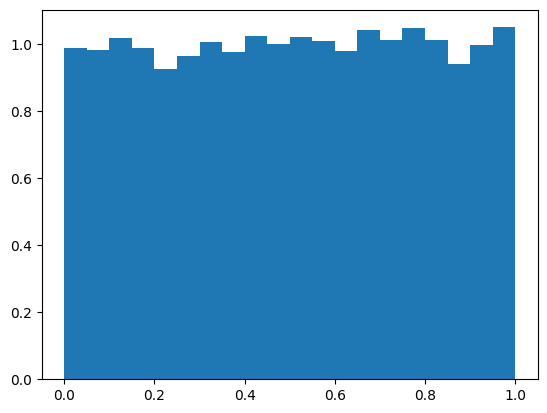

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.hist(random, 20, density=True)
plt.show()

However, the series test shows that the points are located on hyperplanes, which does not fit well with the notion of randomness:

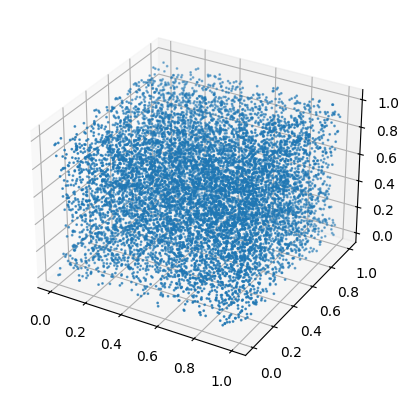

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(random[::3], random[1::3], random[2::3], s=1)
plt.show()

In [ ]:
import plotly.express as px

fig = px.scatter_3d(x=random[::3], y=random[1::3], z=random[2::3], opacity=0.1)
fig.update_traces(marker_size = 2)
fig.show()

### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

In [ ]:
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

samples_bad = [rng_bad() for _ in range(1000)]

result = serial_test(samples[:900], d=3, k=10)  # Test for 3D tuples with 5 bins per dimension
print(result)

result = serial_test(samples_bad[:900], d=3, k=10)  # Test for 3D tuples with 5 bins per dimension
print(result)

{'chi_square_statistic': 1086.6666666666667, 'critical_value': 1073.6426506574246, 'is_random': False}
{'chi_square_statistic': 966.6666666666667, 'critical_value': 1073.6426506574246, 'is_random': True}


* More randomness tests - [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).
* More methods for generating a uniform value [here](https://en.wikipedia.org/wiki/List_of_random_number_generators).
* A story about dynamical systems and the transition to chaos https://www.youtube.com/watch?v=ovJcsL7vyrk&feature=youtu.be

# Generating a sample from a given distribution

Suppose we have a random number generator from the segment [0, 1] (use the `np.random.rand()` function for this). How to get a sample from another distribution $F$?

### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

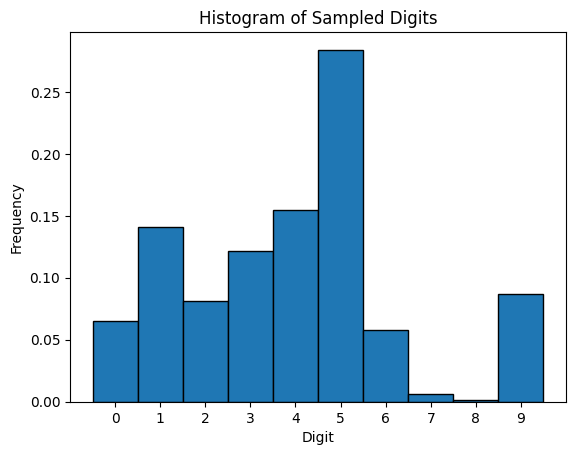

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given data
digits = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])

# Normalize weights (if not already normalized)
weights = weights / np.sum(weights)

# Sort digits and weights in descending order of weights
sorted_indices = np.argsort(weights)[::-1]
sorted_digits = digits[sorted_indices]
sorted_weights = weights[sorted_indices]

# Compute CDF
cdf = np.cumsum(sorted_weights)

# Generate 1000 random numbers
np.random.seed(42)  # For reproducibility
random_numbers = np.random.rand(1000)

# Map random numbers to digits
sample = []
for u in random_numbers:
    index = np.searchsorted(cdf, u, side="right")
    sample.append(sorted_digits[index])

# Convert sample to numpy array
sample = np.array(sample)

# Construct histogram
plt.hist(sample, bins=np.arange(11) - 0.5, edgecolor="black", density=True)
plt.xticks(range(10))
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.title("Histogram of Sampled Digits")
plt.show()

## Inverse transform method

The following proposition is the idea behind the *inverse transform* method:

If $\xi$ has a uniform distribution in $[0,1]$, then $F^{-1}(\xi)$ is distributed according to the law of $F$. (For which $F$ is this true?)

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

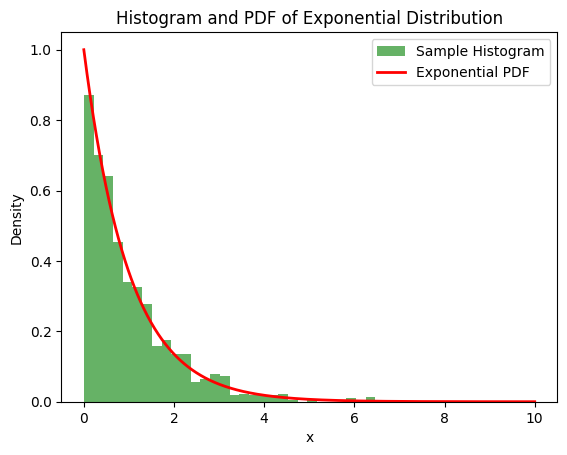

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Parameters
lambda_ = 1.0  # Rate parameter
sample_size = 1000

# Step 1: Generate uniform random numbers
u = np.random.uniform(0, 1, sample_size)

# Step 2: Apply the inverse transform method
x = -np.log(u) / lambda_

# Step 3: Plot the histogram of the sample
plt.hist(x, bins=30, density=True, alpha=0.6, color='g', label='Sample Histogram')

# Step 4: Plot the true exponential density
x_values = np.linspace(0, 10, 1000)
pdf_values = stats.expon.pdf(x_values, scale=1/lambda_)
plt.plot(x_values, pdf_values, 'r-', lw=2, label='Exponential PDF')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Histogram and PDF of Exponential Distribution')
plt.legend()

# Show the plot
plt.show()

## Rejection sampling (Accept-reject method)

The idea of the method is to sample from the distribution we know how to sample from, and then select points that follow the desired distribution. More precisely: let's say we know how to sample from a distribution with density $p$, and we want to sample from a distribution with density $\pi$. Let's take a random $x$ from the distribution $p$. Then take $y$ uniformly distributed on the interval $[0, p(x)]$. If the point $(x, y)$ falls under the graph of $\pi$, we take $x$ as a sampling element from $\pi$. If not, we repeat the procedure for a new $x$. The picture illustrates the idea of the method (the densities are normalised so that one lies entirely under the other):

<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>

### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

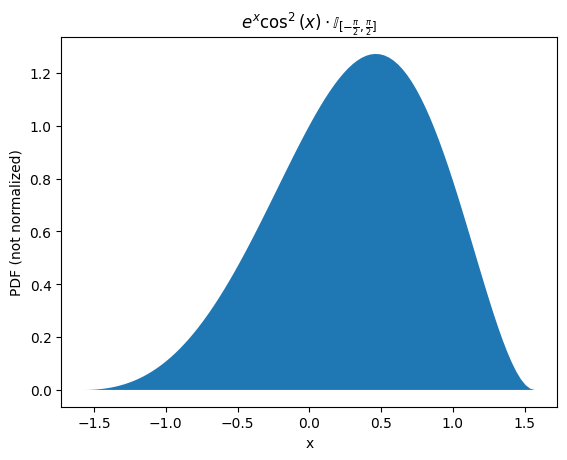

In [ ]:
fig = plt.figure()

x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x) * np.cos(x) ** 2 # not normalized density!
plt.fill_between(x, 0, density)
plt.ylabel('PDF (not normalized)')
plt.xlabel('x')
plt.title(r'$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$')

plt.show()

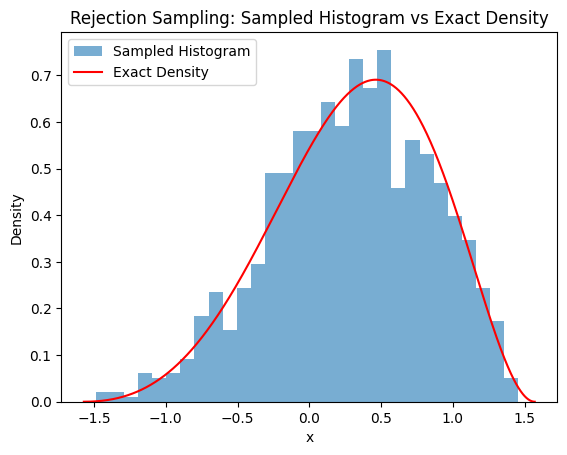

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define the I(-pi/2, pi/2)
I = np.exp(-np.pi / 2) * (2 * np.exp(np.pi) - 2) / 5

# Define the target distribution
def target_distribution(x):
    return np.exp(x) * (np.cos(x))**2 / I

# Define the proposal distribution (uniform)
def proposal_distribution(x):
    return 1 / I

# Define the interval
a, b = -np.pi/2, np.pi/2

# Number of samples
n_samples = 1000

# Accept-Reject Sampling
samples = []
while len(samples) < n_samples:
    x = np.random.uniform(a, b)
    y = np.random.uniform(0, 1.0)
    if y <= target_distribution(x):
        samples.append(x)

# Plot the histogram of the sampled points
plt.hist(samples, bins=30, density=True, alpha=0.6, label='Sampled Histogram')

# Plot the exact density function
x_vals = np.linspace(a, b, 1000)
y_vals = target_distribution(x_vals)
plt.plot(x_vals, y_vals, 'r-', label='Exact Density')

plt.xlabel('x')
plt.ylabel('Density')
plt.title('Rejection Sampling: Sampled Histogram vs Exact Density')
plt.legend()
plt.show()

## Coordinate transformation method

The accept-reject method may in some cases be inefficient and require too many sample points. An alternative is to try to find a coordinate transformation that converts a simple area (from which it is easy to sample, for example, a unit square) into the required area, but preserves the area ratio (why?).

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

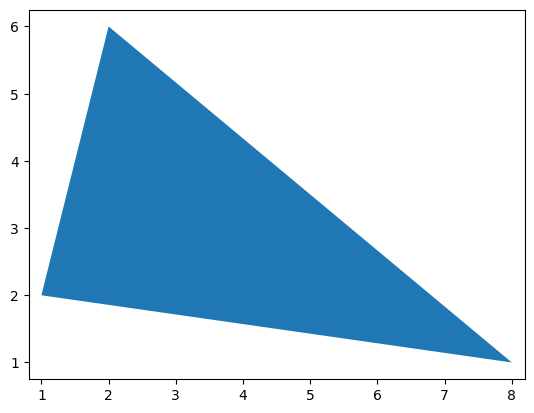

In [ ]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig = plt.figure()

polygon = Polygon(xy=np.array([[1, 2], [2, 6], [8, 1]]), closed=True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.axis('equal')
plt.show()

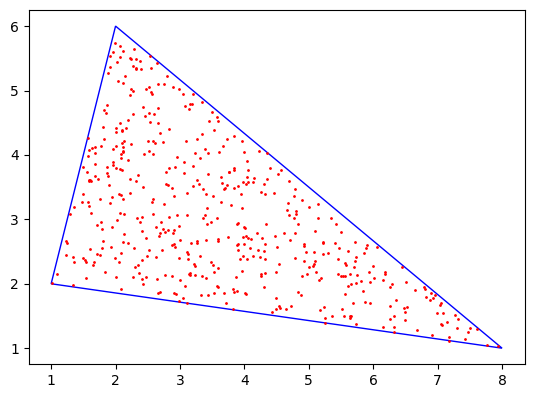

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Define the vertices of the triangle
vertices = np.array([[1, 2], [2, 6], [8, 1]])

# Generate 500 random points uniformly distributed within the triangle
def uniform_triangle_points(vertices, n_points):
    # Generate random points in the unit square
    u = np.random.rand(n_points, 2)

    # Filter points to ensure they are inside the triangle
    mask = u[:, 0] + u[:, 1] > 1
    new_u = u.copy()
    new_u[mask, 0] = 1 - u[mask, 1]
    new_u[mask, 1] = 1 - u[mask, 0]
    u = new_u

    # Convert to barycentric coordinates
    u = u[:n_points]
    points = (1 - u[:, 0] - u[:, 1])[:, np.newaxis] * vertices[0] + \
             u[:, 0][:, np.newaxis] * vertices[1] + \
             u[:, 1][:, np.newaxis] * vertices[2]

    return points

# Generate 500 points
points = uniform_triangle_points(vertices, 500)

# Plot the triangle and the points
fig, ax = plt.subplots()
polygon = Polygon(vertices, closed=True, edgecolor='blue', facecolor='none')
ax.add_patch(polygon)
ax.scatter(points[:, 0], points[:, 1], color='red', s=1)
ax.set_aspect('equal')
plt.show()

### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

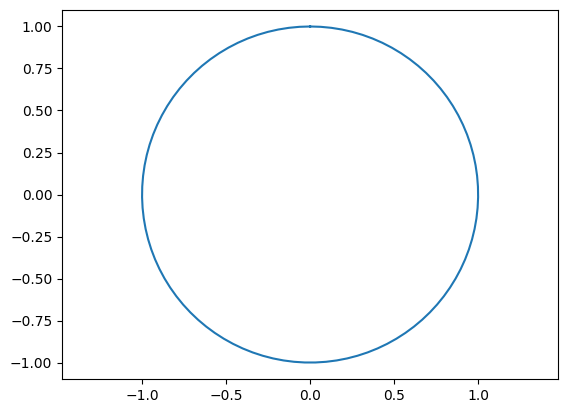

In [ ]:
fig = plt.figure()

t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

(2, 500)


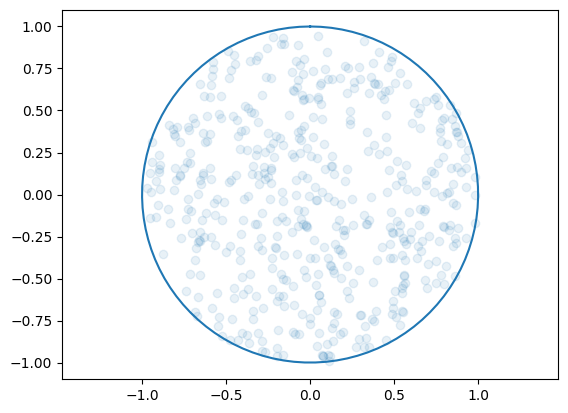

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def transform(u):
    mask = u[:, 0] + u[:, 1] > 1
    new_u = u.copy()
    new_u[mask, 0] = 1 - u[mask, 1]
    new_u[mask, 1] = 1 - u[mask, 0]
    u = new_u

    u[:, 1] = u[:, 1] * 2 * np.pi / (1.0 - u[:, 0])

    phi = u[:, 1]
    r = 1 - u[:, 0]

    x = r * np.cos(phi)
    y = r * np.sin(phi)

    return np.array([x, y])

n_samples = 500

samples = np.random.uniform(0, 1, (n_samples, 2))
samples = transform(samples)

print(samples.shape)


fig = plt.figure()

t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.scatter(samples[0], samples[1], alpha=0.1)
plt.axis('equal')
plt.show()


# Random normal generator

### Problem 9
Prove (orally) that the following algorithm (**Box-Muller algorithm**, https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) generates a sample of independent $\mathcal{N}(0,1)$ random variables. Modify the method to exclude calls of trigonometric functions `np.sin` and `np.cos`. Using the modified method, simulate a sample size of $1000$ from a $2D$ Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$, where
$$\mu = \begin{pmatrix} 4 \\ 7 \end{pmatrix}^T, \quad \Sigma = \begin{pmatrix} 20 & -4 \\ -4 & 40 \end{pmatrix}.$$
Construct a 2D histogram of the resulting distribution. Compare the sample mean and covariance matrix with the exact values.

In [ ]:
import seaborn as sns

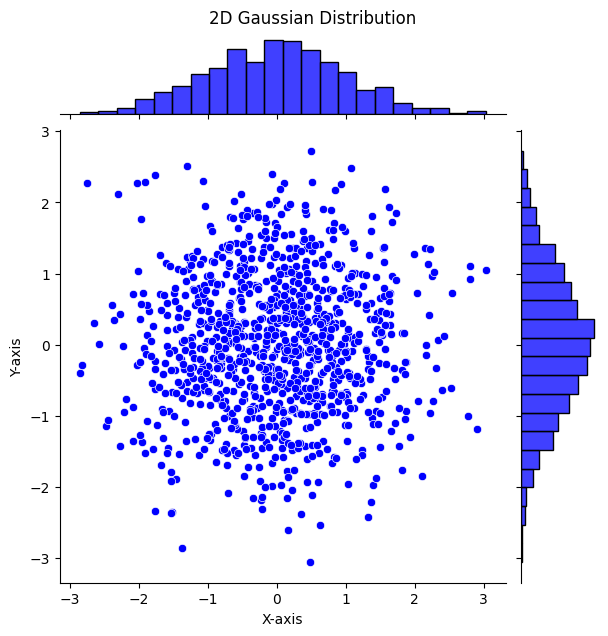

In [ ]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)


joint_plot = sns.jointplot(x=x, y=y, color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

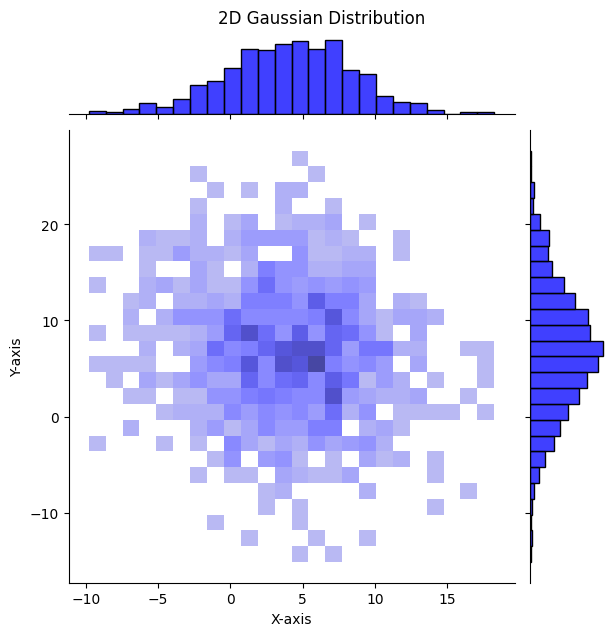

Sample Mean:
 [4.03547955 6.83099075]
Exact Mean:
 [4 7]
Sample Covariance:
 [[20.40419359 -3.75974925]
 [-3.75974925 42.88130985]]
Exact Covariance:
 [[20 -4]
 [-4 40]]


In [ ]:

# Parameters
n = 1000
mu = np.array([4, 7])
Sigma = np.array([[20, -4], [-4, 40]])

# Modified Box-Muller method (Marsaglia polar method)
def marsaglia_polar(n):
    samples = []
    while len(samples) < n:
        u1, u2 = np.random.uniform(-1, 1, 2)
        s = u1**2 + u2**2
        if s < 1:
            factor = np.sqrt(-2 * np.log(s) / s)
            x = u1 * factor
            y = u2 * factor
            samples.append((x, y))
    return np.array(samples).T

# Generate N(0,1) samples
z1, z2 = marsaglia_polar(n)

# Stack into a 2D array
Z = np.vstack((z1, z2))

# Cholesky decomposition of Sigma
L = np.linalg.cholesky(Sigma)

# Transform to desired distribution
X = mu[:, np.newaxis] + L @ Z

# Create 2D histogram
sns.jointplot(x=X[0], y=X[1], kind='hist', color="blue")
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

# Compare sample mean and covariance with exact values
sample_mean = np.mean(X, axis=1)
sample_cov = np.cov(X)

print("Sample Mean:\n", sample_mean)
print("Exact Mean:\n", mu)
print("Sample Covariance:\n", sample_cov)
print("Exact Covariance:\n", Sigma)

### Problem 10*

Implement a method of generating a random partition of an n-element set into subsets. Use it to estimate the expected number of subsets in a random partition of a set of 100 elements.

Hint 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Hint 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [ ]:
# Your code here